<a href="https://colab.research.google.com/github/neuralabc/PythonTools4Neuroimaging/blob/main/PYSC458_03_singleSub_fMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
Now that we have many of the basics under our belt, lets actually **do** an fMRI analysis with some real data.

## Steps to performing a fMRI analysis?

### 1. Study design
Good study design for fMRI is difficult. Creating appropriate control conditions is crucial to the ability to interpret the outcomes of the study.

### 2. Data collection
Data comes from the MRI as `dicom` images, which are 2D "slices" of the final image with metadata that tells where it belongs in a series and what type of sequence it is. We reconstruct the full 3D or 4D image and convert it to a commonly used imaging format, in our case NIFTI (`.nii.gz`), that can be understood by processing tools.

### 3. Preprocessing (at the individual level)
You will not be doing your own preprocessing - we are working with "preprocessed" data. There are many parameters that can be changed during preprocessing, with a multitude of possible effects on the final results.
  - For example, choosing a spatial smoothing kernel that is too large (relative to the expected size of activation in the brain) will decrease the power to detect a real effect.

#### Steps:
  - Motion correction
    - align each of the 3D images within the 4D timeseries so that each voxel has the same location
  - Spatial filtering
    - (optional) smoothes the signal in your data to boost SNR
    - may be performed in the individual or final group space prior to analyses
  - Slice time correction
    - 3D volume not acquired at the same time (top to bottom, left to right)
    - means that your expectations are shifted in time across the brain unless it is corrected
  - Temporal filtering
    - to remove scanner drifts and some physiological noise
  - Physiological noise removal
    - confound regression
  - Spatial registration
    - bring this individual into some common space (usually MNI152)
      - useful for group analyses
      - also for relating your data to atlases (usually also in MNI152 space)
    - this step can take place either before individual stats or after, depending on the needs of the study

### 4. Statistics (at the individual level)
After preprocessing the fMRI data is a 4D timeseries that has had the previous steps applied. Now it is time to think about statistics.
#### Steps:
  - Compute a brain mask
    - there is no sense in performing statistics outside of the brain
    - can also be important for some statistical techniques, since the size of the region included (whole brain, or brain + skull + outside of the head) can affect some algorithms (e.g., Bonferroni correction!)
    - in many cases, white matter is also removed and all analyses are conducted within a grey matter mask
    - there are fairly standard ways to identify regions that exhibit non-random BOLD signal based only on the fMRI data (we use this approach here)
    - this can also be defined on the anatomical T1w image and transformed into the fMRI space (after registration between the two is computed!)
  - Create an `events table` (__unique__ for each participant)
    - the events encodes all of the information about what types of tasks the participant performed within the scanner, when they started, and how long they took to complete
    - normally stored in a spreadsheet-like file that is easily machine readable
      - csv (comma-separated values)
      - tsv (tab-separated values)
      - usually contains `{trial_type, onset, duration}` in columns
  - Generate a `design matrix` that will be used for the statistical model
    - we use the timing and `trial_type` information from the `events table` and convolve it with the haemodynamic response function (HRF) to generate a model of when we _expect_ BOLD activity to differ according to the different conditions (`trial_type`)
    - we also need to know time it takes to acquire each volume of the fMRI time-series so that the function can determine how the HRF maps to volumes
      - this is the repetition time, or `TR` of the scan and is usually found in the metadata
    - the `design matrix` thus models what we expect to happen in the _physiological system of the brain_ at each timepoint (volume / TR) in the scan
    - at this stage, confounds can be added to the model to serve as control variables
    - it is often very important to include these within the model to remove components of signal that would otherwise be attributed to noise and decrease our ability to identify real effects
    - for example, the following are commonly included
      - scanner drifts
        - slow changes in signal across time that are due to the MRI equipment
      - `motion parameters` from the motion correction step
        - even though the images are now all aligned to one another, residual effects are known to occur and introduce false positives and/or noise
      - signal extracted from non-grey matter tissues to serve as `physiological confound` regressors (e.g., mean signal across time from WM and CSF)
        - WM and CSF signal variations encode physiological changes that are expected to be independent of specific BOLD changes that we are trying to identify (and will also be present within GM!)
      - `autoregressive` parameters to correct for the lack of independence between signals at different timepoints
      - derivatives of any/all of the above
  - Fit the model to the fMRI data
    - done for **_each voxel_** and condition of interest, we fit the General Linear Model (GLM) with the specifications of the design matrix
      - equivalent to performing the statistical analysis (e.g., t-test) for each voxel
      - results in 3D maps of the effect for each condition, where the result of the statistical test for each voxel is the value in that voxel!


---

# Statistics (step 4 from above)
As previously, we devote the first execution cell to our main import statments.
- working with data and code is an iterative process that we should note expect to get right the first time
- as such, the imports here should be what we know that we need now, we can always add to it later and re-run the cell!
- throughout this notebook more than the others, there are import statements in specific places
  - these could all be moved up to this location, of course
  - or grouped into logical blocks according to the processing functions that they are supporting later on

We will cover the following practical steps:
1. Identify and download the data
  - Identify the fMRI data file that we will be using
  - Identify the events file that we will be using
4. Take a look at our fMRI data, compute a mask
5. Explore the design of the experiment with the events {trial_type, onset, duration} that were used
6. Create a design matrix
7. Perform the GLM analysis
9. Create contrasts, collect results, plot figures

In [1]:
# we  need a package that is not installed in colab, so lets get that first
#https://nilearn.github.io/
!pip install nilearn #functional MRI processing and statistics, and machine learning for fMRI
# !pip install --upgrade matplotlib==3.3 # we need a specific version of matplotlib to work with nilearn than is available on CoLab

#import the packages that we need
import numpy as np
import nibabel as nb

#now we can load plotting functions and datasets
from nilearn import plotting #https://nilearn.github.io/
from nilearn import datasets #this gives us some access to freely available "testing" data distributed by the community
import matplotlib.pyplot as plt
import pandas as pd #pandas for loading and working with the spreadsheet-like files (csv/tsv/etc) that contain information about the task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 20.3 MB/s eta 0:00:00


## 1. Identify and download the data
  - Identify the fMRI data file that we will be using
  - Identify the events file that we will be using

In [2]:
# lets use the dataset that we used last week
# this data has already been preprocessed and registered to the MNI152 common space
# because of that, all of the plotting functions should "just work" since we are in the standard space that the plotting functions also expect
dataset = datasets.fetch_language_localizer_demo_dataset()


Dataset created in /root/nilearn_data/fMRI-language-localizer-demo-dataset



Downloaded 730537984 of 749503182 bytes (97.5%,    0.5s remaining) ...done. (20 seconds, 0 min)
Extracting data from /root/nilearn_data/fMRI-language-localizer-demo-dataset/fMRI-language-localizer-demo-dataset.zip..... done.


In [3]:
#check out what is in this dataset
dataset

('/root/nilearn_data/fMRI-language-localizer-demo-dataset',
 ['/root/nilearn_data/fMRI-language-localizer-demo-dataset/.bidsignore',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/CHANGES',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/README',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/access_data.py',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/dataset_description.json',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/dataset_description.json',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-confounds_regressors.tsv',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json',
  '/root/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.nii.gz',
  '/root/nilearn_data/fMRI-language-localizer-d

In [4]:
#we will also take a look at the metadata that is stored with this data sample
# it is json format, so we import json to be able to load and create a simple function to print out the json file contents
# the json file is a structured format that stores information in key:value pairs (like a dictionary).
# It is used by the preprocessing scripts to keep track of what the data is and what was done to it. Data provenence
import json
def print_json(file_path):
  print(file_path)
  with open(file=file_path, mode='r') as read_file:
    object = json.load(read_file)
    pretty_object = json.dumps(object, indent=4)
    print(pretty_object)
    print("\n")

In [5]:
print_json('/root/nilearn_data/fMRI-language-localizer-demo-dataset/dataset_description.json')
print_json('/root/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json')

/root/nilearn_data/fMRI-language-localizer-demo-dataset/dataset_description.json
{
    "Name": "language localizer dataset from Neurospin (christophe@pallier.org)",
    "BIDSVersion": "1.2.0",
    "Authors": [
        "Christophe Pallier",
        "Martin Perez Guevara"
    ],
    "License": "ODC-BY-SA",
    "Funding": "ANR CONSTRUCT"
}


/root/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json
{
    "TaskName": "languagelocalizer",
    "RepetitionTime": 1.5
}




In [6]:
#load the language localizer data from the first subject
img = nb.load('/root/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.nii.gz')
events_df = pd.read_csv('/root/nilearn_data/fMRI-language-localizer-demo-dataset/sub-01/func/sub-01_task-languagelocalizer_events.tsv',delimiter='\t') #tsv so we use a tab as the delimiter

## 2. Take a look at the fMRI data, create a mask

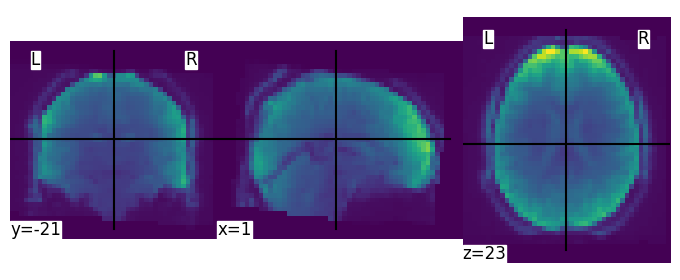

In [7]:
# we don't know if this BOLD timeseries is masked or not (i.e., values outside the brain set to 0), so lets check
from nilearn.image import mean_img
from nilearn.plotting import plot_img
plot_img(mean_img(img))

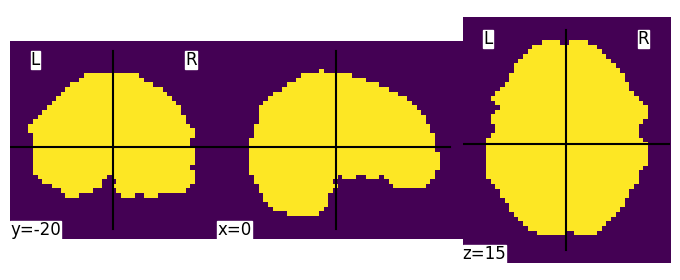

In [8]:
#nope, does not look like a masked image b/c there is a halo of data outside of the brain
# this is the skull

#now lets see if we can get rid of it
from nilearn.masking import compute_epi_mask
epi_mask = compute_epi_mask(img)
plot_img(epi_mask)

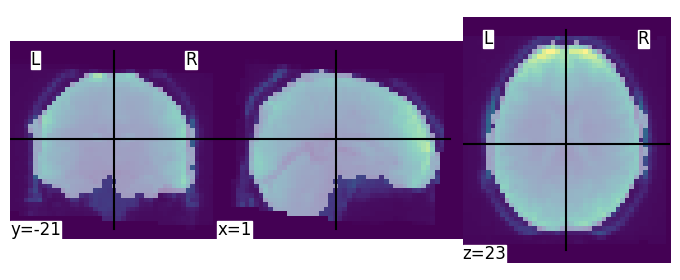

In [9]:
#lets check it relative to the mean of the timeseries
display = plot_img(mean_img(img))
display.add_overlay(epi_mask,alpha=.5,cmap='Greys')
#looks fairly good!
# NOTE: the GLM would autocompute this if we did not specify it

## 3. Explore the design of the experiment with the events {trial_type, onset, duration} that were used
- this will tell us about what the experimental design was like
- it also allows us to explore (a bit later) how the HRF convolution changes the signal that we expect to see in the brain

In [10]:
events_df #lets see what it looks like

onset  duration trial_type
0     3.516     6.806   language
1    17.707     7.004     string
2    32.011     6.805   language
3    46.306     7.206     string
4    60.604     6.804   language
5    74.908     6.804     string
6    89.208     6.808   language
7   103.508     6.806     string
8   117.804     6.806   language
9   132.108     6.809     string
10  146.407     6.805   language
11  160.702     6.807     string
12  175.007     6.804   language
13  189.304     6.805     string
14  203.608     6.802   language
15  217.910     6.806     string
16  232.206     6.809   language
17  246.504     6.802     string
18  260.807     6.800   language
19  275.109     6.806     string
20  289.406     6.806   language
21  303.703     6.803     string
22  318.007     6.807   language
23  332.305     6.810     string

In [11]:
#lets see what the task events look like by plotting it
trial_types = events_df['trial_type'].unique() #get unique trial types, so we can use them to construct a plot
shape = events_df.shape #we take advantage of the fact that we know we have equal numbers of each of the trial types

# we use a dict to create the design mat, allows flexibility for sizes and easy indexing for trials
# in this case we will create a nested dictionary
events_mat = {}
for trial_type in trial_types:
  print(trial_type)
  current_type_df = events_df[events_df['trial_type']==trial_type][['onset','duration']]
  events_mat[trial_type] = current_type_df.to_dict()


language
string


language
string


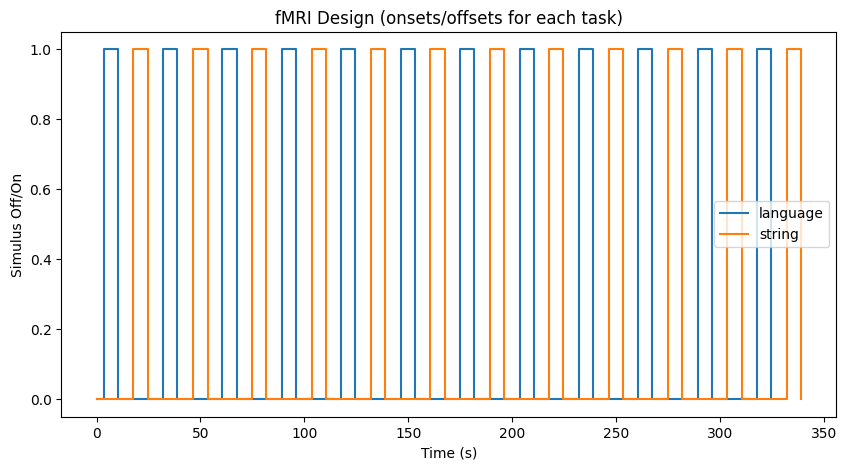

In [12]:
# now that we have prepared the dictionary, lets loop over it to create our plot
plt.figure(figsize=(10,5))
for trial_type in events_mat.keys():
  print(trial_type)
  #convert to numpy arrays
  onsets = np.array(list(events_mat[trial_type]['onset'].values())) # getting here is trial and error, and there are other ways to do this
  duration = np.array(list(events_mat[trial_type]['duration'].values()))
  offsets = onsets+duration

  #now lets construct a design matrix for plotting, were we have a line at 0 when the stimulus is not on and at 1 when it is
  #define the start point for the x and y of our plot
  x = [0]
  y = [0]
  for idx,onset in enumerate(onsets):
    #we need to code the onset at the zero line
    x.append(onsets[idx])
    y.append(0)
    #this is when it turns on, so we build a vertical line here
    x.append(onsets[idx])
    y.append(1)
    #for every onset, we have an offset, so code this as well
    x.append(offsets[idx])
    y.append(1) #we use 1 the first time, so that our plot is square (i.e., build the vertical line down)
    x.append(offsets[idx])
    y.append(0)
  plt.plot(x,y,label=trial_type)

plt.title('fMRI Design (onsets/offsets for each task)')
plt.legend()
_ = plt.xlabel('Time (s)') # used "_" here to suppress output from matplotib, "_" is just a dummy variable that we won't use
_ = plt.ylabel('Simulus Off/On')

## 4. Create a design matrix and Perform the GLM analysis
Includes point 5. from above
- create the model
- fit the model
- investigate the design_matrix that was generated by the fit of the model to the data


In [13]:
# we know what our model looks like, lets do some stats!
from nilearn.glm.first_level import FirstLevelModel
FirstLevelModel?

In [14]:
#construct our first level model
# we need to input the t_r, which is the repetition time from the json above
fmri_glm = FirstLevelModel(t_r=1.5,
                           noise_model='ar1',
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=1./160,
                           signal_scaling=False,
                           minimize_memory=False,mask_img=epi_mask)

In [15]:
fmri_glm.fit(img, events_df)

FirstLevelModel(high_pass=0.00625, hrf_model='spm',
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7957215757e0>,
                minimize_memory=False, signal_scaling=False, t_r=1.5)

In [16]:
#what does our design matrix look like?
fmri_glm.design_matrices_

[       language    string   drift_1   drift_2   drift_3   drift_4  constant
 0.0    0.000000  0.000000  0.093452  0.093445  0.093434  0.093419       1.0
 1.5    0.000000  0.000000  0.093434  0.093375  0.093276  0.093137       1.0
 3.0    0.000000  0.000000  0.093399  0.093234  0.092960  0.092576       1.0
 4.5    0.000533  0.000000  0.093346  0.093023  0.092486  0.091735       1.0
 6.0    0.046264  0.000000  0.093276  0.092742  0.091856  0.090619       1.0
 ...         ...       ...       ...       ...       ...       ...       ...
 336.0 -0.081514  0.196588 -0.093276  0.092742 -0.091856  0.090619       1.0
 337.5 -0.105787  0.496791 -0.093346  0.093023 -0.092486  0.091735       1.0
 339.0 -0.102646  0.786935 -0.093399  0.093234 -0.092960  0.092576       1.0
 340.5 -0.085519  0.984248 -0.093434  0.093375 -0.093276  0.093137       1.0
 342.0 -0.063954  1.011014 -0.093452  0.093445 -0.093434  0.093419       1.0
 
 [229 rows x 7 columns]]

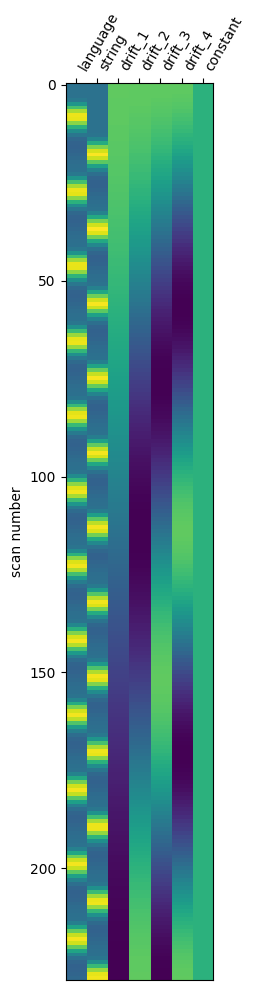

In [17]:
design_matrix = fmri_glm.design_matrices_[0] #rows = time, cols = predictors
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

### How does the design relate to the original events table that we input?
We have now convolved with the HRF, what has that done?

Text(0.5, 1.0, 'Convolved design (expected response)')

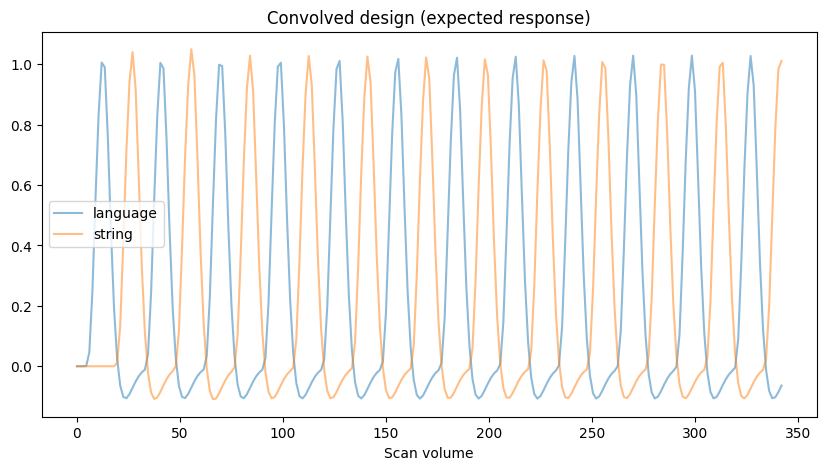

In [18]:
# why is the design not blocky?
#plot the condition again, but this one has been convolved with the HRF
plt.figure(figsize=(10,5))
for trial_type in events_mat.keys():
  plt.plot(design_matrix[trial_type], label=trial_type,alpha=.5)

plt.xlabel('Scan volume')
plt.legend()
plt.title('Convolved design (expected response)')

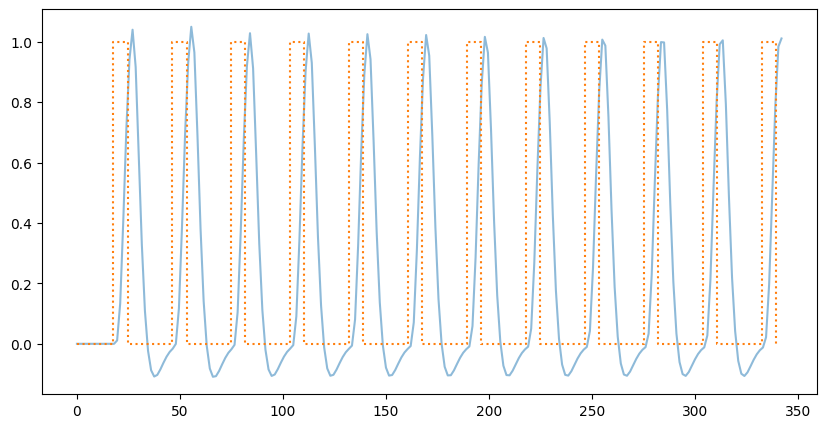

In [19]:
#lets just look at one of them as well, so that we can see what the HRF has done to our design
# what is going on here?
plt.figure(figsize=(10,5))
plt.plot(design_matrix[trial_type], label=trial_type,alpha=.5)
plt.plot(x,y,':')

## 6. Create contrasts, collect results, plot figures
We have run the GLM but we need to extract the results for the contrasts that we are interested in.
- A `contrast` is a comparison of interest for the study
- Note that there are multiple columns in the design matrix (that we just plotted)
- We need to tell the model which one of these we are interested in
  - These can be referred to as "conditions" of the experiment
  - This is done by specifying `1` for an effect of interest or `0` for an effect of no interest (i.e., controlling for)
  - To create a comparison contrast, we also need to use two contrasting numbers, `1` and `-1`
- An example:
  - if you were to ask "what is the main effect of viewing srings of letters" you would createa a contrast that selects only the `strings` `trial_type` and ignores all others
    - `np.array([0,1,0,0,0,0,0])`

Once we have our conditions specified, we compute the contrast.
- **This** is the statistical comparison
- We can specify here what type of statistic we want

Then we can plot our statistical images (stat maps) to see where our effects are. There are many possibilities for how to correct our data for multiple comparisons, threshold, etc.


In [20]:
from nilearn.plotting import plot_contrast_matrix
from nilearn.plotting import plot_stat_map, plot_glass_brain
#lets first look at the design matrix that was created for us, since the model added some extra parameters
# these are the covariates
design_matrix.head()


language  string   drift_1   drift_2   drift_3   drift_4  constant
0.0  0.000000     0.0  0.093452  0.093445  0.093434  0.093419       1.0
1.5  0.000000     0.0  0.093434  0.093375  0.093276  0.093137       1.0
3.0  0.000000     0.0  0.093399  0.093234  0.092960  0.092576       1.0
4.5  0.000533     0.0  0.093346  0.093023  0.092486  0.091735       1.0
6.0  0.046264     0.0  0.093276  0.092742  0.091856  0.090619       1.0

<Axes: label='conditions'>

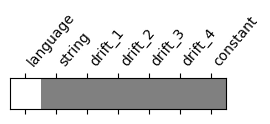

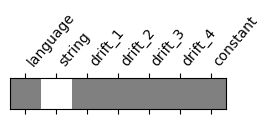

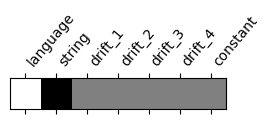

In [21]:
#in this case we have language, string, and 4 "drift" columns, and a constant
# this means we need this number of values to define the conditions that we are interested in
conditions = {'language':np.array([1,0,0,0,0,0,0]),
             'string'  :np.array([0,1,0,0,0,0,0]),
              'language > string': np.array([1,-1,0,0,0,0,0])}

#subsequently, we can define any contrast that we are interested in
# a contrast is just a comparison between BOLD in one condition and another.
# a condition vs rest, or baseline, is also possivle, where it is contrasted to any time that is left unspecified in the design matrix

# lets see what this looks like

plot_contrast_matrix(conditions['language'], design_matrix=design_matrix) # white is "1", grey is "0"
plot_contrast_matrix(conditions['string'], design_matrix=design_matrix)
plot_contrast_matrix(conditions['language > string'], design_matrix=design_matrix) #white is "1", black is "-1"


<class 'nibabel.nifti1.Nifti1Image'>


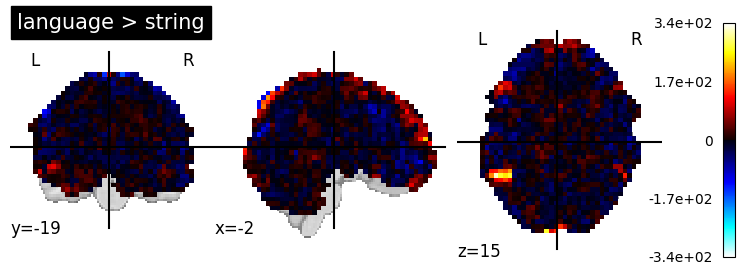

In [22]:
#now we can compute the estimated effect
#NOTE: this is in units of BOLD, and NOT standardized in any way (i.e., it is basically a subtraction of BOLD values)
eff_map = fmri_glm.compute_contrast(conditions['language > string'],
                                    output_type='effect_size')
#this returns a nibabel image, but lets check to be sure
print(type(eff_map))
plot_stat_map(eff_map,title='language > string')

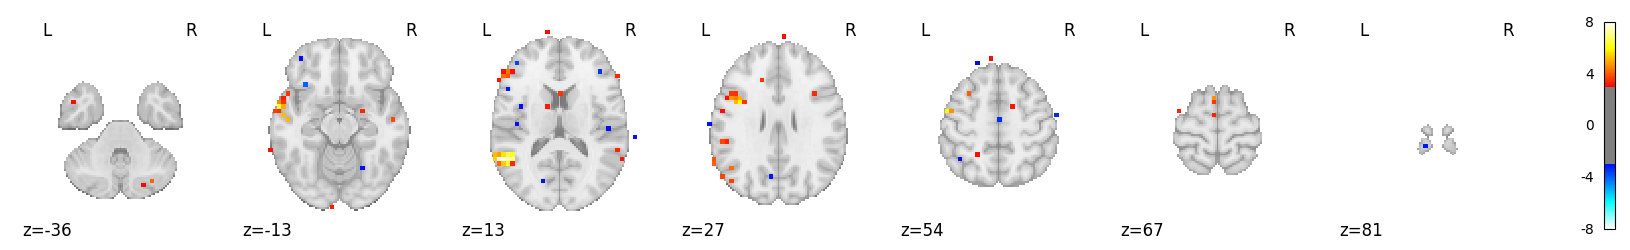

In [23]:
# lets convert the data to something that we can assess significance on - zstats!
z_map = fmri_glm.compute_contrast(conditions['language > string'],
                                  output_type='z_score')
plot_stat_map(z_map,display_mode='z',threshold=3.0)

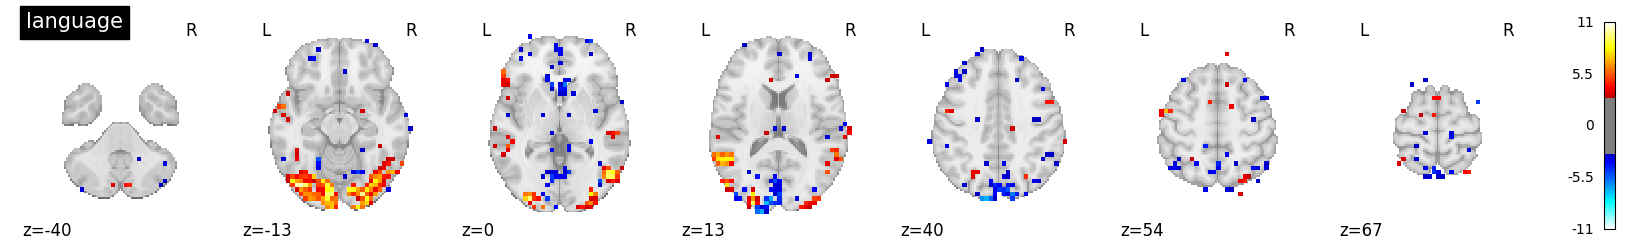

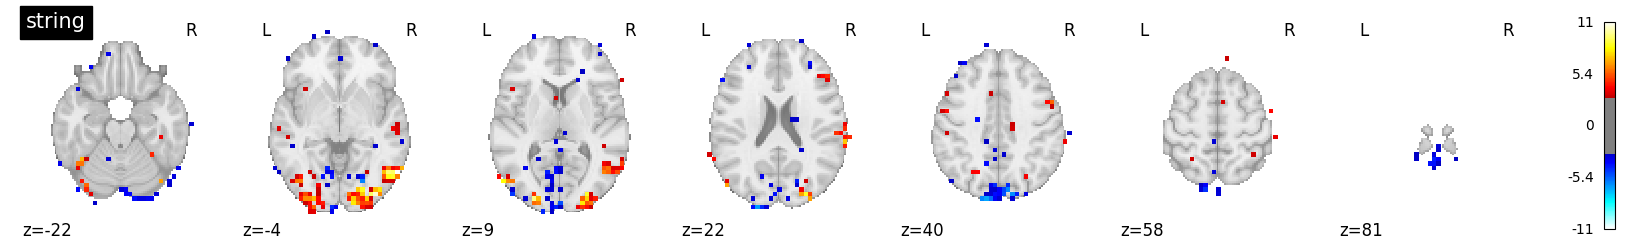

In [24]:
#compare the above result to this one, where we are only looking at the main effect of language
z_map_lang = fmri_glm.compute_contrast(conditions['language'],
                                  output_type='z_score')
plot_stat_map(z_map_lang,display_mode='z',threshold=3,title='language')

#compare the above result to this one, where we are only looking at the main effect of language
z_map_string = fmri_glm.compute_contrast(conditions['string'],
                                  output_type='z_score')
plot_stat_map(z_map_string,display_mode='z',threshold=3,title='string')

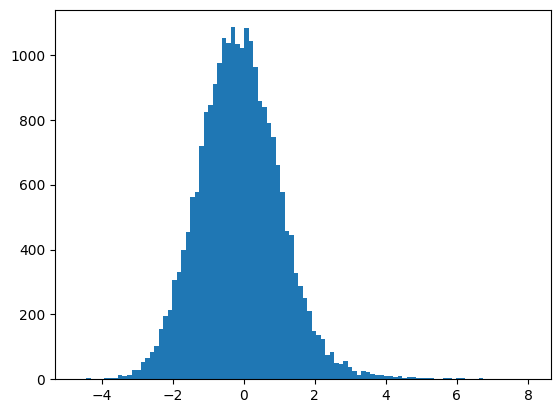

In [25]:
#lets take a quick look at the distribution of the zscores data
d = z_map.get_fdata()
d = d[d!=0] #lets exclude the zeros, since we don't have a brain mask here. This WILL remove some real results though
hh = plt.hist(d,bins=100)

#### Extra: 3D plotting!!!

In [26]:

#plotting interactively in 3D so that we can really see what we have here in the cortex!
from nilearn.plotting import view_img_on_surf
view_img_on_surf(z_map, threshold=3.0, cmap='magma')
